# ***Final Model Summary:***

xgb regressor, most important features are related to distance and spatial data. We tried predicting for house prices in the king county dataset. Here is a summary of a 10 k fold validation giving us a .90 ish average R^2 for the model's performance.

<br>

---

###  **10-Fold Cross Validation**
- Fold 1: R^2 (original scale) = 0.8460, MSE = 29576266362.6804
- Fold 2: R^2 (original scale) = 0.8865, MSE = 15136651169.9921
- Fold 3: R^2 (original scale) = 0.9346, MSE = 9970847033.9324
- Fold 4: R^2 (original scale) = 0.8918, MSE = 13584360485.2610
- Fold 5: R^2 (original scale) = 0.8610, MSE = 25113395123.1089
- Fold 6: R^2 (original scale) = 0.9198, MSE = 9465988009.8092
- Fold 7: R^2 (original scale) = 0.9054, MSE = 10373026551.5374
- Fold 8: R^2 (original scale) = 0.9160, MSE = 9967297064.2364
- Fold 9: R^2 (original scale) = 0.9112, MSE = 10074287599.1319
- Fold 10: R^2 (original scale) = 0.9031, MSE = 10704384280.4973
- Fold 11: R^2 (original scale) = 0.9138, MSE = 10866446922.9651
- Fold 12: R^2 (original scale) = 0.8998, MSE = 12304493537.4271
- Fold 13: R^2 (original scale) = 0.9335, MSE = 8111959883.5605
- Fold 14: R^2 (original scale) = 0.9294, MSE = 10378342097.7444
- Fold 15: R^2 (original scale) = 0.9190, MSE = 9823148170.9505
- Fold 16: R^2 (original scale) = 0.9150, MSE = 11020007376.4782
- Fold 17: R^2 (original scale) = 0.9052, MSE = 10693283376.9012
- Fold 18: R^2 (original scale) = 0.9285, MSE = 13110323073.7280
- Fold 19: R^2 (original scale) = 0.9261, MSE = 11196749930.9733
- Fold 20: R^2 (original scale) = 0.9251, MSE = 8500209368.7259

**Average R^2 (original scale): 0.9085311646063777**

**Average MSE (original scale): 12498573370.982067**

<br>

---

### **Feature Importances**
```
                    feature  importance
         prox_high_zip_flag    0.236901
                  grade_bin    0.225246
             spatial_smooth    0.180521
        sqft_living_x_grade    0.105235
                      grade    0.059832
                  totalsqft    0.034786
                 waterfront    0.034590
                       view    0.024946
            dist_to_seattle    0.016711
                   high_zip    0.011800
                       long    0.008011
                        lat    0.006306
                  condition    0.004944
          sqft_living_x_age    0.004733
               yr_renovated    0.004053
                        age    0.003964
                  total_lot    0.003475
                   yr_built    0.003393
             bath_bed_ratio    0.003236
           dist_to_bellevue    0.003132
 sqft_above_x_sqft_basement    0.002814
                  bathrooms    0.002777
                      month    0.002768
           living_lot_ratio    0.002566
       bedrooms_x_bathrooms    0.002371
                    zipcode    0.002280
years_since_last_renovation    0.001969
             bed_bath_ratio    0.001723
                     floors    0.001590
                no_basement    0.001285
                  renovated    0.001203
                   bedrooms    0.000840
```








---- Feature Importances ----
                    feature  importance
             spatial_smooth    0.268439
        sqft_living_x_grade    0.207304
         prox_high_zip_flag    0.158308
                  grade_bin    0.075389
                 waterfront    0.044259
                      grade    0.036927
                       view    0.035943
            dist_to_seattle    0.025415
                  totalsqft    0.017744
                        lat    0.015636
                   high_zip    0.012810
                       long    0.012284
                  renovated    0.011236
          sqft_living_x_age    0.007685
                  condition    0.007410
                  total_lot    0.005714
               yr_renovated    0.005448
                   yr_built    0.004976
           dist_to_bellevue    0.004856
             bath_bed_ratio    0.004804
           living_lot_ratio    0.004325
 sqft_above_x_sqft_basement    0.004082
                      month    0.004036
       be

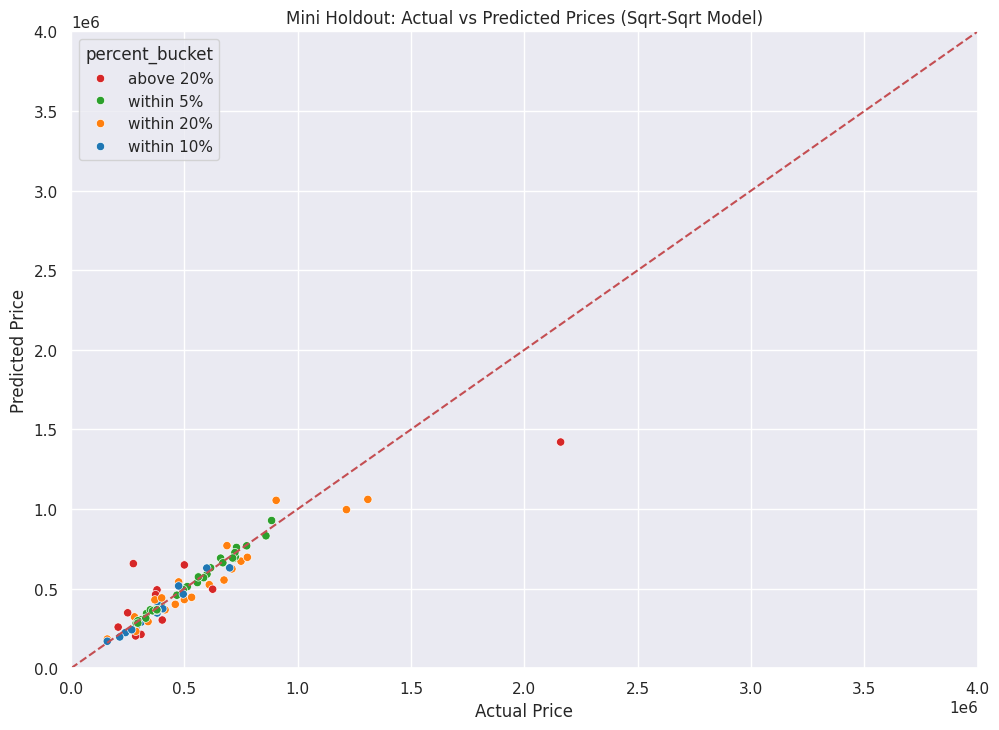

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import radians, sin, cos, acos
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import BallTree


# Helper Functions -------------------------------------------------------------
def haversine_distance(lat1, lon1, lat2, lon2):
    """Return distance in miles between two lat/lon points."""
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    R = 3958.8
    return R * acos(cos(lat1) * cos(lat2) * cos(lon2 - lon1) + sin(lat1) * sin(lat2))


def compute_distance_to_point(df, point_lat, point_lon, col_name):
    """Compute distance from each row (using its lat, long) to a given point."""
    df[col_name] = df.apply(lambda row: haversine_distance(row['lat'], row['long'], point_lat, point_lon), axis=1)
    return df


def compute_spatial_smoothing(train_df, query_df, radius_miles=1.0):
    """
    For each row in query_df, compute the average training price (original price)
    of houses within a given radius (in miles) from training data.
    If query_df is train_df, exclude the house itself.
    Returns a NumPy array of smoothed prices.
    """
    train_coords = np.radians(train_df[['lat', 'long']].values)
    query_coords = np.radians(query_df[['lat', 'long']].values)
    tree = BallTree(train_coords, metric='haversine')
    radius = radius_miles / 3958.8
    smooth_prices = []

    for i, q in enumerate(query_coords):
        inds = tree.query_radius([q], r=radius)[0]
        if train_df is query_df:
            if len(inds) <= 1:
                smooth_prices.append(np.nan)
                continue
            else:
                inds = inds[1:]
        if len(inds) == 0:
            smooth_prices.append(np.nan)
        else:
            smooth_prices.append(train_df.iloc[inds]['price'].mean())

    return np.array(smooth_prices)


def add_geospatial_features(df, train_df=None, smoothing_radius=1.0):
    """
    Add geospatial enrichment features to the DataFrame:
      - dist_to_seattle: distance to downtown Seattle (47.6062, -122.3321)
      - dist_to_bellevue: distance to Bellevue (47.6101, -122.2015)
      - spatial_smooth: average training price of neighbors within smoothing_radius miles,
                        transformed by the fourth-root.
    """
    df = compute_distance_to_point(df, 47.6062, -122.3321, 'dist_to_seattle')
    df = compute_distance_to_point(df, 47.6101, -122.2015, 'dist_to_bellevue')

    if train_df is None:
        smooth = compute_spatial_smoothing(df, df, radius_miles=smoothing_radius)
    else:
        smooth = compute_spatial_smoothing(train_df, df, radius_miles=smoothing_radius)

    overall_median = df['price'].median() if 'price' in df.columns else np.nan
    smooth = np.where(np.isnan(smooth), overall_median, smooth)
    df['spatial_smooth'] = np.power(smooth, 0.25)

    return df


def build_features_custom(df, overall_median, zipcode_to_high_zip, high_zip_centroids, totalsqft_quantile, is_training=True):
    """
    Build features (including geospatial ones) and the target.
    The function:
      - Parses the date.
      - Computes population by zipcode/month/year.
      - Computes high_zip and prox_high_zip_flag.
      - Creates additional features (age, grade_bin, ratios, interactions, etc.).
      - Drops columns not used for modeling.
      - Applies the fourth-root transformation to price if is_training is True.
    """
    df['date_parsed'] = pd.to_datetime(df['date'], format='%Y%m%dT%H%M%S', errors='coerce')
    df['year'] = df['date_parsed'].dt.year
    df['month'] = df['date_parsed'].dt.month
    df['day'] = df['date_parsed'].dt.day

    pop_df = df.groupby(['zipcode', 'year', 'month']).size().reset_index(name='population')
    df = df.merge(pop_df, on=['zipcode', 'year', 'month'], how='left')
    df['population'] = df['population'].fillna(0).astype(int)

    df['high_zip'] = df['zipcode'].map(zipcode_to_high_zip).fillna(0).astype(int)

    def get_prox_high_zip(row, centroids, threshold_miles=0.5):
        if centroids:
            dists = [haversine_distance(row['lat'], row['long'], clat, clon) for clat, clon in centroids]
            return 1 if (row['high_zip'] == 1 or min(dists) < threshold_miles) else 0
        else:
            return row['high_zip']

    df['prox_high_zip_flag'] = df.apply(lambda row: get_prox_high_zip(row, high_zip_centroids), axis=1)

    df['renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
    df['age'] = 2024 - df['yr_built']
    df['grade_bin'] = pd.cut(df['grade'], bins=[0, 3, 7, 13], labels=[0, 1, 2]).astype(int)
    df['no_bathrooms'] = df['bathrooms'].apply(lambda x: 1 if x == 0 else 0)
    df['no_basement'] = df['sqft_basement'].apply(lambda x: 1 if x == 0 else 0)
    df['years_since_last_renovation'] = df.apply(lambda row: (row['yr_renovated'] - row['yr_built']) if (row['yr_renovated'] - row['yr_built']) >= 0 else 0, axis=1)
    df['living_lot_ratio'] = df['sqft_living'] / (df['sqft_lot'] + 1)
    df['bath_bed_ratio'] = df['bathrooms'] / (df['bedrooms'] + 1)
    df['bed_bath_ratio'] = df['bedrooms'] / (df['bathrooms'] + 1)
    df['sqft_living_x_grade'] = df['sqft_living'] * df['grade']
    df['sqft_living_x_age'] = df['sqft_living'] * df['age']
    df['bedrooms_x_bathrooms'] = df['bedrooms'] * df['bathrooms']
    df['sqft_above_x_sqft_basement'] = df['sqft_above'] * df['sqft_basement']

    df['weird1'] = df['bathrooms'].apply(lambda x: 1 if (x > 7 or x == 0) else 0)
    df['weird2'] = df['bedrooms'].apply(lambda x: 1 if (x > 20 or x == 0) else 0)
    df['weirdos'] = df['weird1'] + df['weird2']
    df.drop(columns=['weird1', 'weird2'], inplace=True)

    df['totalsqft'] = df['sqft_living'] + df['sqft_above'] + df['sqft_basement'] + df['sqft_living15']
    df['total_lot'] = df['sqft_lot'] + df['sqft_lot15']
    df['totalsqft'] = df['totalsqft'].apply(lambda x: totalsqft_quantile if x > 30000 else x)

    drop_cols = ['id', 'date', 'date_parsed', 'day', 'population', 'year',
                 'sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot', 'sqft_lot15']
    df.drop(columns=drop_cols, inplace=True, errors='ignore')

    df['zipcode'] = df['zipcode'].astype(int)

    if is_training and 'price' in df.columns:
        df['price'] = np.power(df['price'], 0.25)
        y = df['price']
        X = df.drop('price', axis=1)
    else:
        y = None
        X = df.copy()

    return X, y

def bucket_error(p):
    if p <= 5:
        return 'within 5%'
    elif p <= 10:
        return 'within 10%'
    elif p <= 20:
        return 'within 20%'
    else:
        return 'above 20%'


# Main Pipeline ----------------------------------------------------------------
train_df = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv")

train_totalsqft = train_df['sqft_living'] + train_df['sqft_above'] + train_df['sqft_basement'] + train_df['sqft_living15']
totalsqft_quantile_train = train_totalsqft.quantile(0.999)
overall_median_train = train_df['price'].median()
zip_median_train = train_df.groupby('zipcode')['price'].median()
zip_to_high_train = (zip_median_train > overall_median_train).astype(int).to_dict()

temp_train = train_df.copy()
temp_train['high_zip'] = temp_train.groupby('zipcode')['price'].transform('median') > overall_median_train
high_zip_data = temp_train[temp_train['high_zip'] == True]
high_zip_centroids = high_zip_data.groupby('zipcode').agg({'lat': 'mean', 'long': 'mean'}).reset_index()
high_zip_centroids_list = list(zip(high_zip_centroids['lat'], high_zip_centroids['long']))

train_df = add_geospatial_features(train_df, train_df, smoothing_radius=1.0)

X_train, y_train = build_features_custom(train_df.copy(), overall_median_train, zip_to_high_train,
                                           high_zip_centroids_list, totalsqft_quantile_train, is_training=True)

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

final_model = XGBRegressor(objective='reg:squarederror', random_state=42,
                           subsample=0.8, n_estimators=400, max_depth=5,
                           learning_rate=0.1, colsample_bytree=0.9,
                           reg_alpha=0.1, reg_lambda=1)
final_model.fit(X_train_scaled, y_train)

importances = final_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)
print("\n---- Feature Importances ----")
print(importance_df.to_string(index=False))


# Mini Holdout Test ------------------------------------------------------------
mini_holdout = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv")
mini_holdout['zipcode'] = mini_holdout['zipcode'].astype(int)
mini_answers = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini_answers.csv")
mini_holdout['actual_price'] = mini_answers['price']

mini_merged = add_geospatial_features(mini_holdout, train_df, smoothing_radius=1.0)
mini_merged_features = mini_merged.drop(columns=['actual_price'])
X_mini, _ = build_features_custom(mini_merged_features.copy(), overall_median_train,
                                  zip_to_high_train, high_zip_centroids_list, totalsqft_quantile_train,
                                  is_training=False)
X_mini_scaled = scaler.transform(X_mini)

preds_mini = final_model.predict(X_mini_scaled)
preds_mini_orig = np.power(preds_mini, 4)
mini_merged['predictions'] = preds_mini_orig

r2_mini = r2_score(mini_merged['actual_price'], mini_merged['predictions'])
mse_mini = mean_squared_error(mini_merged['actual_price'], mini_merged['predictions'])
rmse_mini = np.sqrt(mse_mini)
mae_mini = mean_absolute_error(mini_merged['actual_price'], mini_merged['predictions'])
medae_mini = median_absolute_error(mini_merged['actual_price'], mini_merged['predictions'])

mini_merged['abspercentmiss'] = (np.abs(mini_merged['predictions'] - mini_merged['actual_price']) / mini_merged['actual_price']) * 100
mini_holdout_buckets = mini_merged['abspercentmiss'].apply(bucket_error)
mini_merged['percent_bucket'] = mini_holdout_buckets

print("\n---- Mini Holdout Performance ----")
print(f"Within 5%: {((mini_merged['abspercentmiss']<=5).mean()*100):.2f}%")
print(f"Within 10%: {((mini_merged['abspercentmiss']<=10).mean()*100):.2f}%")
print(f"Within 20%: {((mini_merged['abspercentmiss']<=20).mean()*100):.2f}%")
print(f"R^2: {r2_mini:.4f}")
print(f"RMSE: {rmse_mini:.2f}")
print(f"Mean Absolute Error: {mae_mini:.2f}")
print(f"Median Absolute Error: {medae_mini:.2f}")

sns.set(rc={'figure.figsize': (11.7, 8.27)})
ax = sns.scatterplot(data=mini_merged, x='actual_price', y='predictions', hue='percent_bucket',
                     palette={'within 5%': 'tab:green', 'within 10%': 'tab:blue', 'within 20%': 'tab:orange', 'above 20%': 'tab:red'})
ax.plot((0, 4e6), (0, 4e6), color='r', linestyle='--')
ax.set(xlim=(0, 4e6), ylim=(0, 4e6))
ax.set_title("Mini Holdout: Actual vs Predicted Prices (Sqrt-Sqrt Model)")
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
plt.show()


# **Conclusion:**

The model did well in train and validation. It fell down a little bit in mini holdout test, but we think it will do well on the bigger holdout since it has more datapoints.